#  Starbucks

## 1. Business Understanding
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

# Part I A/B Testing Case Study

## 2. Data Understanding

In [1]:
# load in packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from test_results import test_results
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [2]:
# number of columns and rows
train_data.shape

(84534, 10)

In [3]:
# number of columns with no missing values
len(train_data.columns[train_data.isnull().sum()==0])

10

There aren't any mussing values

In [4]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [5]:
# the possible number of purchases
train_data.purchase.unique()

array([0, 1])

In [6]:
train_data.groupby("Promotion").size()

Promotion
No     42170
Yes    42364
dtype: int64

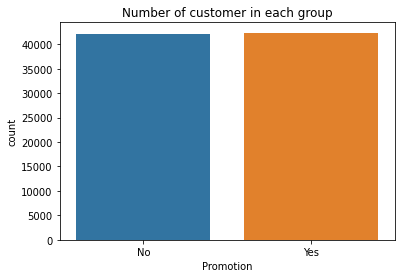

In [7]:
sns.countplot(x="Promotion", data=train_data)
plt.title("Number of customer in each group");

The number of customers in control and treatment group is almost the same

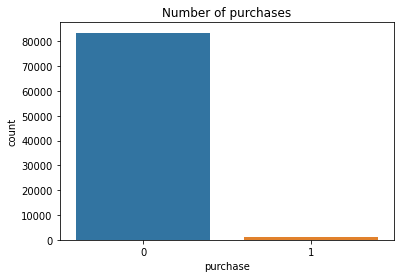

In [8]:
sns.countplot(x="purchase", data=train_data)
plt.title("Number of purchases");

In [9]:
train_data["purchase"].mean()

0.012302742091939338

Approximately 1% of customer made the purchase

In [10]:
data_purchase=train_data[train_data.purchase==1]

In [11]:
data_purchase = data_purchase.groupby("Promotion").size().reset_index()

In [12]:
data_purchase

,Promotion,0
0,No,319
1,Yes,721


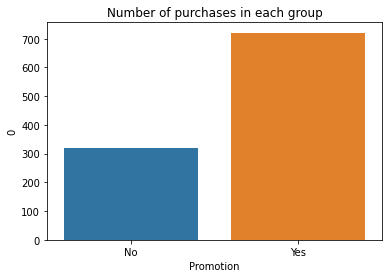

In [13]:
sns.barplot(x="Promotion",y=0, data=data_purchase)
plt.title("Number of purchases in each group");

### Checking the Invariant Metric

The first step is to check the _invariance metrics_. That means that the number of participants in control and the experimental groups are approximately the same.  This is the core step before we start with evaluation metrics in order to be sure that the future inferences are based on strong ground.   If it is not the case, we can’t do other validations of experiment and we must do deep analysis whether there are any issues with assignments or do we have any sources of bias.   

In this study I will use a two-sided hypothesis test.


### Analytic Approach

In [14]:
# get number of trials and number of promotions
n_obs = train_data.shape[0]
n_control = train_data.groupby('Promotion').size()[0]
n_control

42170

In [15]:
# Compute a z-score and p-value
p = 0.5
sd = np.sqrt(p * (1-p) * n_obs)

z = ((n_control + 0.5) - p * n_obs) / sd

print(z)
print(2 * stats.norm.cdf(z))

-0.6638066506192843
0.5068140685419046


There isn’t any statistically significant difference between two groups. So, I will move to the evaluation metrics

### Checking the Evaluation Metric

The second step is to perform hypothesis test and identify whether the promotion had a significant effect or not. As optimization metrics we use IRR and NIR.

For the hypothesis test we  alpha value = 0.05. However, for this hypothesis test we involve multiple metrics. For that reason, we have to do a correction on Type I error (rejection of a true null hypothesis) in order to keep overall error rate at the the desired level.


$$ \alpha_{ind}= \frac{\alpha_{over}}{n} $$

$$ \alpha_{ind}= \frac{0.05}{2}= 0.025 $$

In [16]:
def calculate_irr(data):
    """
    Calculate Incremental Response Rate (IRR)
    
    Input:
    data: pandas data frame
    
    Output:
    irr:float (see the formula below)
    
    """
    # calculate relationship between contol group and purchases
    n_ctrl = data.groupby('Promotion').size()[0]
    condition_ctrl = len(data[(data.Promotion=="No")&(data.purchase==1)])/n_ctrl
    # calculate relationship between experimental group and purchases
    n_treat = data.groupby('Promotion').size()[1]
    condition_treat = len(data[(data.Promotion=="Yes")&(data.purchase==1)])/n_treat
    return condition_treat-condition_ctrl

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

In [17]:
def calculate_nir(data):
    """
    Calculate Net Incremental Revenue (NIR)
    
    Input:
    data: pandas data frame
    
    Output:
    irr:float (see the formula below)
    
    """
    cust_treat = len(data[data.Promotion=="Yes"])
    purch_treat = len(data[(data.Promotion=="Yes")&(data.purchase==1)])
    purch_ctrl = len(data[(data.Promotion=="No")&(data.purchase==1)])
    return (10*purch_treat - 0.15*cust_treat) - 10*purch_ctrl

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

In [1]:
def bootstrapping (data, metric=True, c = .975, n_trials = 10000):
    """
    Compute a confidence interval for a quantile of a 
    dataset using a bootstrap method
    
    Input parameters:
        data:  pandas dataframe
        metric: str name of metric to use irr or nir
        c: confidence interval width
        n_trials: number of bootstrap samples to perform
    
    Output value:
        ci: Tuple indicating lower and upper bounds of bootstrapped
            confidence interval
        sample_metrics list list of sampled quantiles 
    """
    
    # initialize storage of bootstrapped sample quantiles
    n_points = data.shape[0] 
    sample_metrics = []
    
    # For each trial...
    for _ in range(n_trials):
        # draw a random sample from the data with replacement...
        sample = data.sample(n_points, replace = True)
        
        # compute the desired metric...
        if metric =="irr":
            sample_metric = calculate_irr(sample)
            
        if metric == "nir":
            sample_metric = calculate_nir(sample)
        
        # and add the value to the list of sampled quantiles
        sample_metrics.append(sample_metric)
        
    # Compute the confidence interval bounds
    lower_limit = np.percentile(sample_metrics, (1 - c)/2 * 100)
    upper_limit = np.percentile(sample_metrics, (1 + c)/2 * 100)
    
    
    return sample_metrics, lower_limit, upper_limit

In [19]:
def plot_results(diffs,upper_q,lower_q, param_label):
    '''
    for more information please read this article 
    https://towardsdatascience.com/experimental-design-bootstrapping-5b56fc7a10f1
    inputs:
        diffs: list: difference in the average revenue for page_versions
        upper_q: float: upper quantile
        lower_q: float: lower quantile
        param_label: str: name of calculated metric
        
    returns: 
        None
    '''
    # create the figure size
    plt.figure(figsize=(20,5))

    
    # plot lower, upper, and null value
    plt.axvline(upper_q, 0, 1, color='blue', linestyle = '--', label='97.5% bounds for diff \n at {} and {}.'.format(round(lower_q,3), round(upper_q,3)))
    plt.axvline(lower_q, 0, 1, color='blue', linestyle = '--')
    plt.axvline(0, 0, 1, color='red')

    # plot diffs
    plt.hist(diffs, bins=20, density=True);
    plt.title('Histogram of the Bootstrap Difference');
    plt.xlabel('Difference in '+ param_label);
    plt.grid(False);

    plt.legend();
    plt.show();

## 1. Incremental Response Rate (IRR)

The hypothesis is on Incremental Response Rate (IRR)
1.	H_0:   IRR <= 0
2.	H_alt : IRR > 0


In [20]:
IRR = calculate_irr(train_data)
IRR 

0.009454547819772702

In [21]:
sample_irr,lower_limit_irr, upper_limit_irr = bootstrapping(train_data, metric="irr")

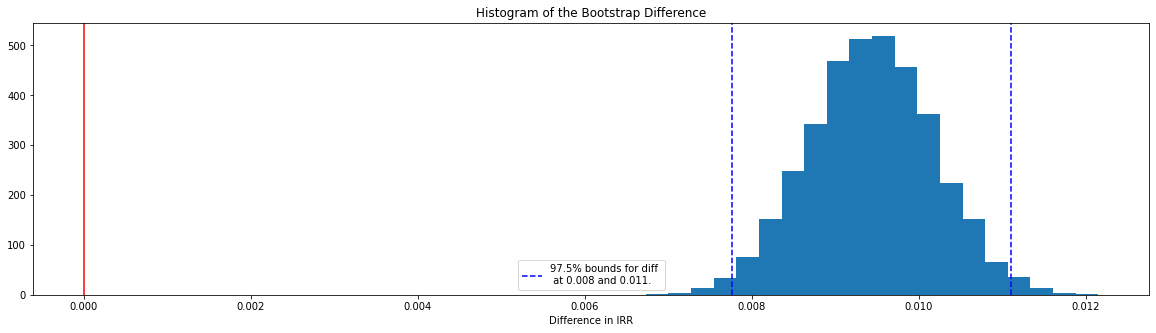

In [22]:
plot_results(sample_irr,upper_limit_irr,lower_limit_irr, "IRR")

In [23]:
p_value = 1 - stats.norm.cdf(IRR, 0, np.std(sample_irr))
p_value

0.0

The diagram above shows that the middle 97.5 % doesn’t contain the difference of zero. Also, the average difference of bootstrapped samples lies in-between confidence interval. Due to that, the experiment was statistically significant on IRR metric. Additionally, The p value is under critical alpha value. So, we reject null hypothesis   

## 2. Net Incremental Revenue (NIR)

The hypothesis is on Net Incremental Revenue (NIR)
1.	H_0:   NIR <= 0
2.	H_alt : NIR > 0

In [24]:
NIR = calculate_nir(train_data)
NIR

-2334.5999999999995

In [25]:
sample_nir,lower_limit_nir, upper_limit_nir =  bootstrapping(train_data, metric="nir")

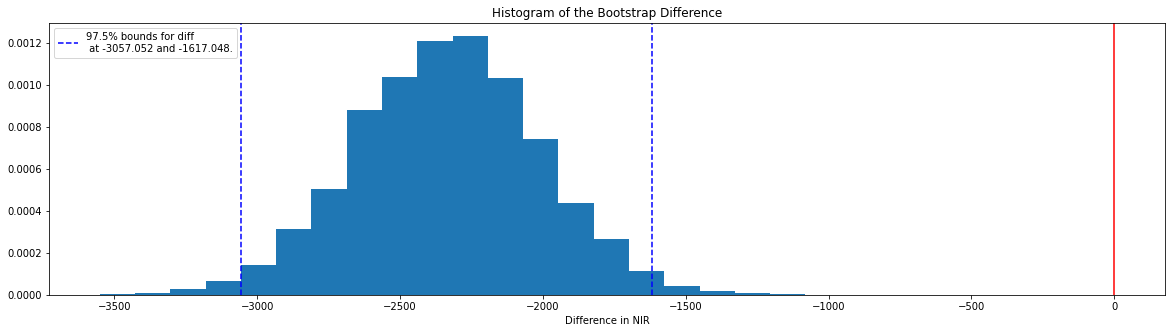

In [26]:
plot_results(sample_nir,upper_limit_nir,lower_limit_nir, "NIR")

In [27]:
p_value = 1 - stats.norm.cdf(NIR, 0, np.std(sample_nir))
p_value

0.9999999999998568

The graphic shows that the observed values for NIR metric are negative.The p value is above our critical alpha. So, we fail to reject null hypothesis. 

To sum up, the promotion strategy was successful on IRR but doesn’t achieve the desired results in NIR metric.  Therefore, the targeted approach of customers should have a better impact on the profit rather than randomly assignment.   

For this reason, the further step is to build machine learning model which is capable to automatically identify the customer who are more receptive to the promotion. 

# Part II Machine Learning 

## 3. Prepare Data

In [28]:
X = train_data.drop(['ID','purchase','Promotion'], axis=1)
Y = train_data['purchase']

## 4. Data Modeling

In [29]:
def eval_model(x_test, y_test, model):
    """
    Input: 
        x_test: pandas dataframe:  input features
        y_test: y: pandas Series: labels
        model: classification model
    Output: None
    """
    results = model.predict(x_test)
    print(classification_report(y_test, results))
    


In [30]:
def param_tuning(x, y):
    """
    RandomizedSearch for parameter tunung
    Input:
        x: pandas dataframe:  input features
        y: pandas Series: labels
    Output:
        optimized model
    """
    # the maximum depth of the tree
    max_depth = [int(x) for x in np.linspace(2, 30, num = 10)]
    # The number of trees in the forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
    # The number of features to consider when looking for the best split
    max_features = [None, 'sqrt',0.3, 0.4, 0.5 ]
    
    random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features}
    clf = RandomForestClassifier(random_state=0,class_weight="balanced_subsample" )
    clf_randomized = RandomizedSearchCV(clf,random_grid,cv=3,n_iter = 150, n_jobs=2, scoring="roc_auc")
    return clf_randomized.fit(x,y)
    

In [31]:
# clf_rf = param_tuning(X_test,Y_test)

In [32]:
clf_rf = RandomForestClassifier(random_state=0, class_weight="balanced_subsample",n_estimators=700,max_depth=5 )

In [33]:
clf_rf.fit(X,Y)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       n_estimators=700, random_state=0)

In [34]:
def label_converter(y_results):
    """
    Convert 0/1 to yes/no
    Input:
        y_results: numpy.ndarray: predicted labels
    Output:
        numpy.ndarray: with yes/no labels
        
    """
    
    promotion = []
    for i in y_results:
        if i ==0:
            promotion.append("No")
        else:
            promotion.append("Yes")
    return np.asarray(promotion)
        

## 5. Conclusion

In [35]:
test_data = pd.read_csv('Test.csv')
X_test = test_data.drop(['ID','purchase','Promotion'], axis=1)
Y_test = test_data['purchase']

In [36]:
eval_model(X_test,Y_test,clf_rf)

              precision    recall  f1-score   support

           0       0.99      0.56      0.72     41170
           1       0.02      0.66      0.03       480

    accuracy                           0.56     41650
   macro avg       0.51      0.61      0.38     41650
weighted avg       0.98      0.56      0.71     41650



In [37]:
def promotion_strategy(df, model):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)
    model: classification model
    
    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    results = model.predict(df)
    
    promotion = label_converter(results)
    return promotion

In [38]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy, clf_rf)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0199.

Your nir with this strategy is 430.70.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.019888163066550765, 430.70000000000005)